In [1]:
%run common.ipy

Using DW in /home/davo/Documents/GRASIA/daostack-notebooks/datawarehouse from date 2023-05-01T00:00:00
DW version 1.1.9
dao-analyzer version: 1.2.6
cache-scripts version: 1.1.9


In [2]:
# Data tools
import pandas as pd
import numpy as np

# Visualizationhttps://github.com/plotly/dash/pull/2473/files
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Jupyter
from IPython.display import HTML
import ipywidgets as widgets

# Local modules
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport utils.plot
%aimport utils.tables

# Datos generales

## ¿Cuantas DAOs existen?

In [3]:
dfd = utils.get_df('dfd').reset_index()
dfd[dfd['register'] == 'registered']['network'].value_counts()

xdai       35
mainnet    23
Name: network, dtype: Int64

In [4]:
dfd[dfd['register'] != 'registered']['network'].value_counts()

xdai       32
mainnet     2
Name: network, dtype: Int64

### ¿Cuantas DAOs dropeamos?

In [5]:
def _dropLessThan3Users(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['nusers'] >= 3]

alldaos = utils.get_df('dfd').groupby('network')['id'].count()
nondropped1 = utils.dropDAOs(utils.get_df('dfd')).groupby('network')['id'].count()
nondropped = _dropLessThan3Users(utils.dropDAOs(utils.get_df('dfd'))).groupby('network')['id'].count()
dropped = alldaos - nondropped

print("Original:", alldaos)
print("Restantes:", nondropped1)
print("Restantes (nusers > 2):", nondropped)
print("Eliminadas:", dropped)

Original: network
mainnet    25
xdai       67
Name: id, dtype: int64
Restantes: network
mainnet    18
xdai        8
Name: id, dtype: int64
Restantes (nusers > 2): network
mainnet    18
xdai        8
Name: id, dtype: int64
Eliminadas: network
mainnet     7
xdai       59
Name: id, dtype: int64


## ¿Cuántas DAOs han estado activas?

In [6]:
dfd['hasActivity'] = (dfd['cntActivity'] > 0)
n_no_activity = (~dfd['hasActivity']).sum()
total = dfd['hasActivity'].count()
print(f"Total without activity: {n_no_activity} ({n_no_activity/total*100:.2f}%)")
dfd.groupby(['network', 'register'])[['hasActivity']].value_counts()

Total without activity: 25 (27.17%)


network  register      hasActivity
mainnet  registered    True           22
                       False           1
         unRegistered  True            2
xdai     registered    True           34
                       False           1
         unRegistered  False          23
                       True            9
dtype: int64

### ¿Cuántas DAOs tienen al menos una propuesta?

In [7]:
dfd['hasProposals'] = (dfd['nproposals'] > 0)
n_no_proposals = (~dfd['hasProposals']).sum()
print(f"Total with votes: {dfd['hasProposals'].sum()} ({dfd['hasProposals'].sum()/total*100:.2f}%)")
print(f"Total without votes: {n_no_proposals} ({n_no_proposals/total*100:.2f}%)")
print(dfd.groupby(['network', 'register'])[['hasProposals']].value_counts())
print(dfd.groupby(['network'])[['hasProposals']].value_counts())

Total with votes: 67 (72.83%)
Total without votes: 25 (27.17%)
network  register      hasProposals
mainnet  registered    True            22
                       False            1
         unRegistered  True             2
xdai     registered    True            34
                       False            1
         unRegistered  False           23
                       True             9
dtype: int64
network  hasProposals
mainnet  True            24
         False            1
xdai     True            43
         False           24
dtype: int64


### ¿Cuantas DAOs tienen al menos un voto?

In [8]:
dfd['hasVotes'] = (dfd['nvotes'] > 0)
n_no_votes = (~dfd['hasVotes']).sum()
print(f"Total with votes: {dfd['hasVotes'].sum()} ({dfd['hasVotes'].sum()/total*100:.2f}%)")
print(f"Total without votes: {n_no_votes} ({n_no_votes/total*100:.2f}%)")
print(dfd.groupby(['network', 'register'])[['hasVotes']].value_counts())
print(dfd.groupby(['network'])[['hasVotes']].value_counts())

Total with votes: 64 (69.57%)
Total without votes: 28 (30.43%)
network  register      hasVotes
mainnet  registered    True        21
                       False        2
         unRegistered  True         2
xdai     registered    True        34
                       False        1
         unRegistered  False       25
                       True         7
dtype: int64
network  hasVotes
mainnet  True        23
         False        2
xdai     True        41
         False       26
dtype: int64


### ¿Cuantas DAOs tienen más de una propuesta?

In [9]:
dfd['hasProposals2'] = (dfd['nproposals'] > 1)
n_no_proposals = (~dfd['hasProposals2']).sum()
print(f"Total with proposals: {dfd['hasProposals2'].sum()} ({dfd['hasProposals2'].sum()/total*100:.2f}%)")
print(f"Total without proposals: {n_no_proposals} ({n_no_proposals/total*100:.2f}%)")
print(dfd.groupby(['network', 'register'])[['hasProposals2']].value_counts())
print(dfd.groupby(['network'])[['hasProposals2']].value_counts())

Total with proposals: 53 (57.61%)
Total without proposals: 39 (42.39%)
network  register      hasProposals2
mainnet  registered    True             19
                       False             4
         unRegistered  True              2
xdai     registered    True             24
                       False            11
         unRegistered  False            24
                       True              8
dtype: int64
network  hasProposals2
mainnet  True             21
         False             4
xdai     False            35
         True             32
dtype: int64


## ¿Cuanto tiempo han estado activas las DAOs?

There are 23 gDAOs with more than 0 years of life
There are 6 gDAOs with more than 1 years of life
   CuraDAO, Genesis Alpha, PolkaDAO, dOrg, dxDAO, necDAO
There are 2 gDAOs with more than 2 years of life
   dOrg, dxDAO
There are 1 gDAOs with more than 3 years of life
   dxDAO


<Axes: ylabel='Frequency'>

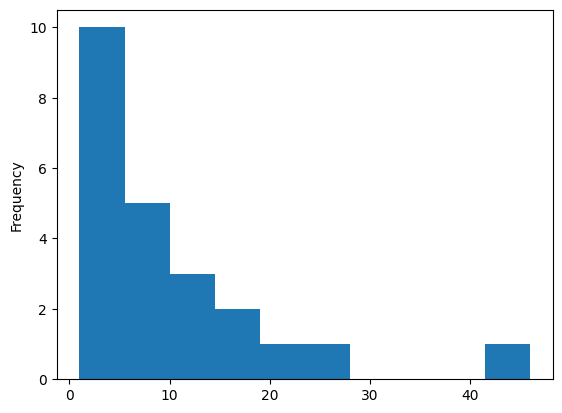

In [10]:
dfg = utils.get_df('dfg')
dfa = utils.append_dao_info(utils.get_df('dfa'))
dfa['atMonth'] = dfa['at'].dt.to_period('M')

dfg['monthsWithProposals'] = dfa[dfa['kind'] == 'proposing'].groupby('group')['atMonth'].nunique()

for i in range(4):
    x = dfg[dfg['monthsWithProposals'] >= i*12]
    print(f"There are {len(x)} gDAOs with more than {i} years of life")
    if len(x) < 10:
        print("  ", ", ".join(x.index))
dfg['monthsWithProposals'].plot.hist()

There are 23 gDAOs with more than 0 years of life
There are 9 gDAOs with more than 1 years of life
   CuraDAO, DAOfund, FestDAO, Genesis Alpha, PolkaDAO, PrimeDAO, dOrg, dxDAO, necDAO
There are 4 gDAOs with more than 2 years of life
   CuraDAO, dOrg, dxDAO, necDAO
There are 2 gDAOs with more than 3 years of life
   dxDAO, necDAO


<Axes: ylabel='Frequency'>

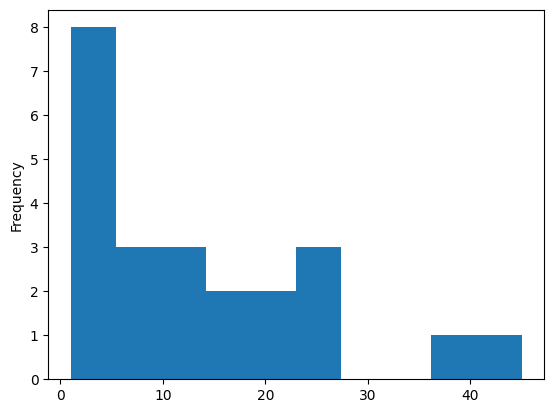

In [11]:
for i in range(4):
    x = dfg[dfg['diff'] >= i*12]
    print(f"There are {len(x)} gDAOs with more than {i} years of life")
    if len(x) < 10:
        print("  ", ", ".join(x.index))
dfg['diff'].plot.hist()

## Correlación entre miembros de DAOs

Como vamos a tener $2^n$ combinaciones, es hora de quedarnos con unas pocas DAOs.

Comparing 20 DAOs
saving to ../logseq/assets/nb_figures/DAOs/dao_users_heatmap.png
Figure is Axes
Use ![% de usuarios de una DAO (A) que están en otra DAO (B)](../assets/nb_figures/DAOs/dao_users_heatmap.png) to embed it in logseq


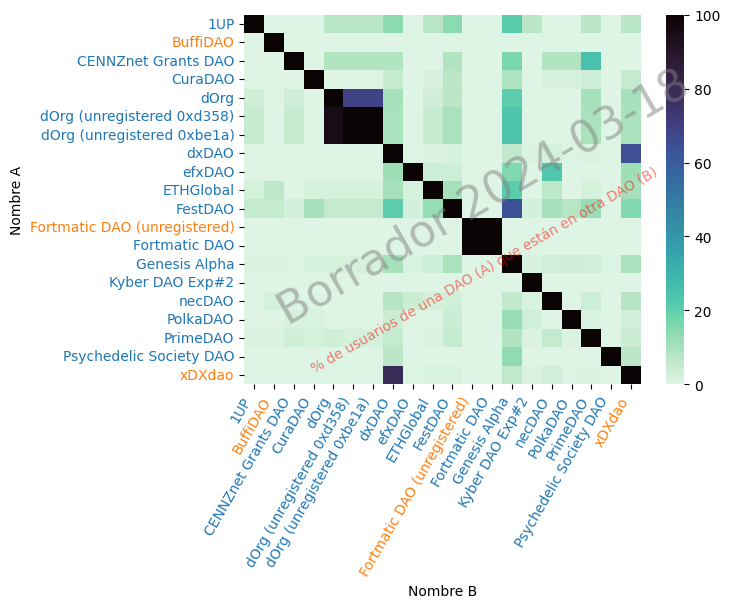

In [12]:
dfh = utils.get_df('dfh')
dfd_filtered = dfd[dfd['nusers'] > 10].sort_values('name', key=lambda x: x.str.lower())
print(f"Comparing {len(dfd_filtered)} DAOs")

dao_names = utils.append_dao_names(dfd_filtered[['network', 'dao']]).set_index('dao')['name']

def compare_to_every(daoid: str, daos = dfd_filtered['dao']) -> pd.DataFrame:
    """ Receives a DAO and returns a data frame of the percentages of users in common with every other DAO """
    df = pd.DataFrame(index=daos)
    dao_holders = set(dfh[dfh['dao'] == daoid]['address'])
    for d in daos:
        df.loc[d, 'cntCommon'] = len(dao_holders & set(dfh[dfh['dao'] == d]['address']))
        df.loc[d, 'pctCommon'] = df.loc[d, 'cntCommon'] / len(dao_holders) * 100
        
    return df

def compare_to_every_total(row, **kwargs):
    return compare_to_every(row.name, **kwargs)['cntCommon']

def compare_to_every_pct(row, **kwargs):
    return compare_to_every(row.name, **kwargs)['pctCommon']

# display(dfd_filtered.set_index('dao').apply(compare_to_every_total, axis='columns').set_index(dao_names).rename(columns=dao_names))
_pairwise_df = dfd_filtered \
                .set_index('dao') \
                .apply(compare_to_every_pct, axis='columns')

ax = sns.heatmap(_pairwise_df,
                 cmap=utils.plot.default_heatmap_cmap,
                 # annot=True,
                 fmt='.0f',
)

ax.set_title('% de usuarios de una DAO (A) que están en otra DAO (B)')
ax.set_ylabel('Nombre A')
ax.set_xlabel('Nombre B')

# No me preguntes por qué, pero parece que no le pone los colores desde aquí, hay que ponerlos luego ¿?
ax.set_xticklabels(utils.plot.get_colored_dao_labels_from_ids(dfd_filtered), rotation=60, ha='right')
ax.set_yticklabels(utils.plot.get_colored_dao_labels_from_ids(dfd_filtered))

for tx, ty, t in zip(ax.get_xticklabels(), ax.get_yticklabels(), utils.plot.get_colored_dao_labels_from_ids(dfd_filtered)):
    tx.set_color(t.get_color())
    ty.set_color(t.get_color())

utils.plot.save_fig(ax, 'DAOs/dao_users_heatmap.png', debug=True, bbox_inches='tight')

En concreto, cuantos usuarios de Genesis Alpha están en otra DAO

In [13]:
GENESIS_ID = dfd[dfd['name'] == 'Genesis Alpha']['dao'].iloc[0]
_dfd = dfd.set_index('dao')

print("Genesis id:", GENESIS_ID)

dao_holders_GENESIS = set(dfh[dfh['dao'] == GENESIS_ID]['address'])
dao_holders_in_other = dao_holders_GENESIS & set(dfh[dfh['dao'] != GENESIS_ID]['address'])
dao_holders_in_other_except = dao_holders_in_other - dao_holders_GENESIS
print("GA holders", len(dao_holders_GENESIS))
print("GA holder in other DAOs:", len(dao_holders_in_other))

Genesis id: 0x294f999356ed03347c7a23bcbcf8d33fa41dc830
GA holders 266
GA holder in other DAOs: 72


## Correlación entre miembros por grupo

Comparing 14 groups
saving to ../logseq/assets/nb_figures/DAOs/group_users_heatmap.png
Figure is Axes
Use ![% de usuarios de un grupo (A) que están en otro grupo (B)](../assets/nb_figures/DAOs/group_users_heatmap.png) to embed it in logseq


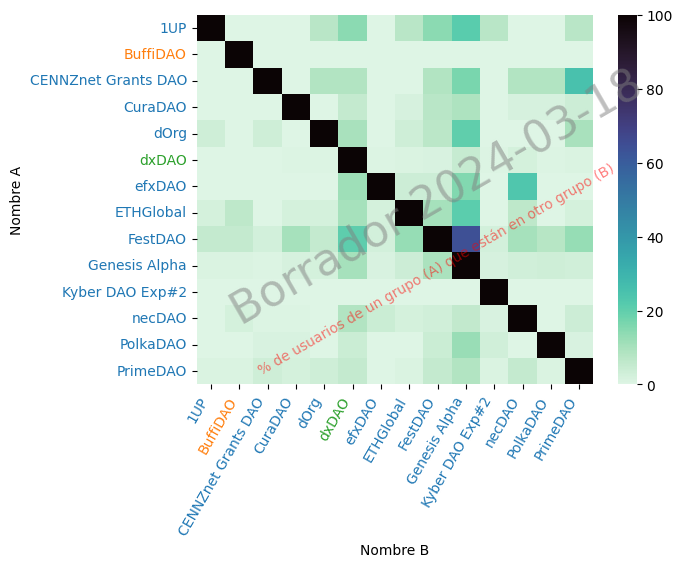

In [14]:
dfh = utils.get_df('dfh')
dfg = utils.get_df('dfg').reset_index()
dfg_filtered = dfg[dfg['nusers'] > 10].sort_values('group', key=lambda x: x.str.lower())
print(f"Comparing {len(dfg_filtered)} groups")

def compare_to_everyg(gid: str) -> pd.DataFrame:
    """ Receives a DAO and returns a dataframe of the percentages of users in common with every other DAO """
    df = pd.DataFrame(index=dfg_filtered['group'])
    dao_holders = set(dfh[dfh['group'] == gid]['address'])
    for g in dfg_filtered['group']:
        dao_holders2 = set(dfh[dfh['group'] == g]['address'])
        df.loc[g, 'cntCommon'] = len(dao_holders & dao_holders2)
        df.loc[g, 'pctCommon'] = df.loc[g, 'cntCommon'] / len(dao_holders) * 100
        
    return df

def compare_to_every_totalg(row):
    return compare_to_everyg(row.name)['cntCommon']

def compare_to_every_pctg(row):
    return compare_to_everyg(row.name)['pctCommon']

_pairwise_df = dfg_filtered \
                .set_index('group') \
                .apply(compare_to_every_pctg, axis='columns')

ax = sns.heatmap(_pairwise_df,
                 cmap=utils.plot.default_heatmap_cmap,
                 # annot=True,
                 fmt='.0f',
)

ax.set_title('% de usuarios de un grupo (A) que están en otro grupo (B)')
ax.set_ylabel('Nombre A')
ax.set_xlabel('Nombre B')

# No me preguntes por qué, pero parece que no le pone los colores desde aquí, hay que ponerlos luego ¿?
ax.set_xticklabels(utils.plot.get_colored_dao_labels_from_network(dfg_filtered, namecol='group'), rotation=60, ha='right')
ax.set_yticklabels(utils.plot.get_colored_dao_labels_from_network(dfg_filtered, namecol='group'))

for tx, ty, t in zip(ax.get_xticklabels(), ax.get_yticklabels(), utils.plot.get_colored_dao_labels_from_network(dfg_filtered, namecol='group')):
    tx.set_color(t.get_color())
    ty.set_color(t.get_color())

utils.plot.save_fig(ax, 'DAOs/group_users_heatmap.png', debug=True, bbox_inches='tight')

## Tabla resumen de DAOs

In [15]:
DORG_ADDRESSES = ["0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6", "0xbe1a98d3452f6da6e0984589e545d4fc25af7526", "0xd358d4f159e6fae32d1b6096bdace829a5fe33fb"]

def aggregate_dOrg(df):
    return df

utils.dropDAOs(dfd.set_index(['network', 'dao'])).iloc[0]

id                         0x0b93ba560283350d4216f29dc57e15df38d0eace
name                                                          CuraDAO
register                                                   registered
nativeToken                0x2d3ca07e3c36b9aeec572a3c625cb45a7a88984a
nativeReputation           0xe2c2bbf97599c448aba4561006c8d5929ac08e13
nusers                                                             55
hnusers                                                          55.0
firstUser                                         2019-07-07 14:29:29
firstActivity                                     2019-08-06 22:47:40
lastActivity                                      2021-08-18 07:03:19
lastVote                                          2021-08-18 06:46:13
cntActivity                                                       209
nvotes                                                            103
nstakes                                                            57
nproposals          

In [16]:
DISPLAY_COLS = ['name', 'firstActivity', 'lastVote', 'diff', 'monthsWithProposals', 'nproposals', 'pctApproved', 'pctBoosted', 'hnusers', 'nvoters (pct)', 'nproposers (pct)', 'vpp', 'spp']
dfact = utils.get_df('dfa')

_table = utils.get_df('dfd')
# _table['nvoters (pct)'] = _table['nvoters'].apply(lambda x: f'{x:.0f}') + ' ' + (_table['nvoters']/_table['hnusers']).apply(utils.tables.custom_pct_format)
_table = utils.tables.add_pct_col(_table, 'nvoters', 'hnusers')
_table = utils.tables.add_pct_col(_table, 'nproposers', 'hnusers')
# Número de meses entre first y last Activity
_table['diff'] = np.ceil((_table['lastVote'] - _table['firstActivity'])/np.timedelta64(1, 'M'))

_table = utils.dropDAOs(_table)
_table = utils.append_dao_names(_table.drop(columns='name'))
# _table = _table.sort_values('nproposals', ascending=False).head(20)
_table = _table.sort_values('name')

_table = _table[['network'] + DISPLAY_COLS]
# Set color of table and hide some columns
s = _table.style.apply(utils.tables.nameColorByNetwork, axis=None) \
    .hide(['network', 'pctApproved', 'pctBoosted', 'vpp', 'spp'], 'columns') \
    .hide(axis='index') \
    .format(lambda d:d.strftime('%b \'%y') if not pd.isna(d) else d, subset=['firstActivity','lastVote']) \
    .format(lambda d:f'{d:.0f}', subset=['diff', 'monthsWithProposals', 'hnusers']) \
    .format(lambda d:f'{d*100:.2g}%', subset=['pctApproved', 'pctBoosted']) \
    .format(lambda d:f'{d:.2g}', subset=['vpp', 'spp'])
# utils.tables.save_table_image(s, "DAOs/resumen.png")
s

## Tabla resumen sin dividir en red (sin filtro)

In [17]:
WANTED_COLS = ['hnusers', 'cntActivity', 'nvotes', 'nstakes', 'nproposals', 'pctActive', 'monthsWithActivity']
dfd = utils.get_df('dfd')[WANTED_COLS]
dfd.describe(percentiles=[.25,.50,.75,.85,.90,.95]).transpose()

count        mean          std       min       25%  \
hnusers              92.0  105.891304   592.611495  0.000000  1.000000   
cntActivity          92.0  244.423913  1146.414240  0.000000  0.000000   
nvotes               92.0  145.760870   706.791798  0.000000  0.000000   
nstakes              92.0   55.543478   264.055289  0.000000  0.000000   
nproposals           92.0   43.119565   182.732786  0.000000  0.000000   
pctActive            67.0    0.119517     0.199667  0.023256  0.027027   
monthsWithActivity   67.0    4.611940     7.613694  1.000000  1.000000   

                         50%        75%         85%       90%         95%  \
hnusers             3.000000   7.000000   23.050000   47.1000  197.600000   
cntActivity         4.000000  21.500000  108.300000  229.7000  475.700000   
nvotes              2.000000  12.750000   50.450000  129.1000  267.800000   
nstakes             0.000000   0.000000   29.700000   51.7000   99.100000   
nproposals          2.000000   9.250000   32.450000   48.5000  104.450000   
pctActive           0.027027   0.136111    0.188027    0.3438    0.429716   
monthsWithActivity  1.000000   5.000000    8.200000   13.2000   17.700000   

                            max  
hnusers             4946.000000  
cntActivity         9342.000000  
nvotes              5913.000000  
nstakes             1991.000000  
nproposals          1438.000000  
pctActive              1.045455  
monthsWithActivity    46.000000

## ¿Cuantas DAOs tienen más de 23 miembros?

In [18]:
len(dfd[dfd['hnusers'] > 20])

15

In [19]:
len(dfd[dfd['hnusers'] > 23])

14

In [20]:
(dfd['hnusers'] > 100).sum()

6

## Tabla resumen resumen sin dividir en red (filtradas)

In [21]:
WANTED_COLS = ['hnusers', 'cntActivity', 'nvotes', 'nstakes', 'nproposals', 'pctActive', 'monthsWithActivity']

dfd_filtered = utils.dropDAOs(utils.get_df('dfd'))
dfd_filtered[WANTED_COLS].describe(percentiles=[.25,.50,.75,.85,.90,.95]).transpose()

count        mean          std       min        25%  \
hnusers              26.0  368.153846  1085.629981  4.000000   7.250000   
cntActivity          26.0  854.423077  2060.192946  5.000000  36.500000   
nvotes               26.0  510.884615  1274.792166  3.000000  20.750000   
nstakes              26.0  196.269231   474.435290  0.000000   2.000000   
nproposals           26.0  147.269231   325.253201  2.000000  13.750000   
pctActive            26.0    0.254859     0.270949  0.027027   0.085201   
monthsWithActivity   26.0    9.884615    10.211080  1.000000   3.250000   

                           50%       75%         85%         90%          95%  \
hnusers              25.500000   89.7500  301.500000   445.50000  2244.750000   
cntActivity         129.000000  339.5000  713.250000  2443.50000  4428.000000   
nvotes               57.500000  202.5000  462.750000  1523.00000  2475.250000   
nstakes              33.500000   71.5000  127.750000   615.00000  1167.500000   
nproposals           38.500000   75.5000  174.500000   352.00000   785.250000   
pctActive             0.160627    0.3593    0.407623     0.48538     0.908365   
monthsWithActivity    6.500000   14.2500   17.250000    19.00000    26.750000   

                            max  
hnusers             4946.000000  
cntActivity         9342.000000  
nvotes              5913.000000  
nstakes             1991.000000  
nproposals          1438.000000  
pctActive              1.045455  
monthsWithActivity    46.000000

In [22]:
print("nusers >10:", (dfd_filtered['hnusers'] > 10).sum())
print("nusers >20:", (dfd_filtered['hnusers'] > 20).sum())
print("nusers >350:", (dfd_filtered['hnusers'] > 350).sum())
print("nprop >100:", (dfd_filtered['nproposals'] > 100).sum())

nusers >10: 17
nusers >20: 15
nusers >350: 4
nprop >100: 5


In [23]:
dfd_filtered[dfd_filtered['nproposals'] > 1000]

id  \
network dao                                                                                      
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f  0xe716ec63c5673b3a4732d22909b38d779fa47c3f   

                                                      name    register  \
network dao                                                              
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f  xDXdao  registered   

                                                                                   nativeToken  \
network dao                                                                                      
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f  0xf255b9d83db924820ee23a7dcc30b7542e201bb1   

                                                                              nativeReputation  \
network dao                                                                                      
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f  0xed77eaa9590cfce0a126bab3d8a6ada9a393d4f6   

                                                    nusers  hnusers  \
network dao                                                           
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f     401    402.0   

                                                             firstUser  \
network dao                                                              
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f 2020-11-17 08:45:40   

                                                         firstActivity  \
network dao                                                              
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f 2020-11-23 17:44:25   

                                                          lastActivity  ...  \
network dao                                                             ...   
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f 2023-04-07 19:41:05  ...   

                                                      TN    FP    FN  \
network dao                                                            
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f  80.0  18.0  19.0   

                                                    precision  \
network dao                                                     
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f    0.97427   

                                                    precision_boosted  \
network dao                                                             
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f           0.986557   

                                                    precision_nonboosted  \
network dao                                                                
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f              0.808081   

                                                    nvoters  nproposers  \
network dao                                                               
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f     92.0        97.0   

                                                       shortid  group  
network dao                                                            
xdai    0xe716ec63c5673b3a4732d22909b38d779fa47c3f  3877039203  dxDAO  

[1 rows x 37 columns]

## Tabla resumen resumen por red

In [24]:
WANTED_COLS = ['nusers', 'cntActivity', 'nvotes', 'nstakes', 'nproposals', 'pctActive']
# WANTED_METRICS = ["mean", "std", "50%", '75%', 'max']

dfd_filtered = utils.dropDAOs(utils.get_df('dfd'))
print("Dropping columns:", set(dfd_filtered.columns) - set(WANTED_COLS))
dfd_filtered = dfd_filtered[WANTED_COLS]
d = dfd_filtered.groupby('network').describe(percentiles=[.25, .50, .75, .90, .95])
print(d[('cntActivity', 'count')])
# d = d.loc[:, (slice(None), WANTED_METRICS)]
d.transpose()

Dropping columns: {'group', 'hnusers', 'nvoters', 'nativeReputation', 'firstUser', 'FP', 'nproposers', 'precision_boosted', 'monthsWithActivity', 'TP', 'TN', 'id', 'register', 'name', 'precision_nonboosted', 'shortid', 'lastVote', 'firstActivity', 'monthSinceFirstActivity', 'vpp', 'pctStaked', 'monthsWithProposals', 'pctApproved', 'monthsSinceLastActivity', 'FN', 'pctBoosted', 'nativeToken', 'spp', 'precision', 'lastActivity', 'monthsSinceFirstUser'}
network
mainnet    18.0
xdai        8.0
Name: (cntActivity, count), dtype: float64


network                mainnet      xdai   
nusers      count    18.000000     8.000000
            mean    349.722222   395.375000
            std    1153.359023   953.437980
            min       6.000000     4.000000
            25%      15.750000     4.750000
            50%      34.000000     6.000000
            75%      89.500000   105.500000
            90%     332.600000  1099.700000
            95%    1156.700000  1914.850000
            max    4946.000000  2730.000000
cntActivity count    18.000000     8.000000
            mean    706.611111  1187.000000
            std    1302.175110  3295.137630
            min      34.000000     5.000000
            25%     106.500000    15.750000
            50%     220.500000    22.000000
            75%     399.250000    33.500000
            90%    1953.300000  2833.400000
            95%    3820.800000  6087.700000
            max    4681.000000  9342.000000
nvotes      count    18.000000     8.000000
            mean    404.388889   750.500000
            std     747.741394  2085.970689
            min      23.000000     3.000000
            25%      49.750000    11.750000
            50%     117.500000    15.000000
            75%     211.000000    16.250000
            90%    1251.000000  1787.900000
            95%    2257.450000  3850.450000
            max    2566.000000  5913.000000
nstakes     count    18.000000     8.000000
            mean    172.666667   249.375000
            std     353.806694   703.723350
            min       0.000000     0.000000
            25%      29.500000     0.000000
            50%      50.500000     0.000000
            75%      80.500000     2.000000
            90%     429.400000   598.700000
            95%    1096.700000  1294.850000
            max    1197.000000  1991.000000
nproposals  count    18.000000     8.000000
            mean    129.555556   187.125000
            std     222.006683   505.471050
            min      11.000000     2.000000
            25%      31.750000     4.000000
            50%      46.500000     7.000000
            75%      85.000000    15.250000
            90%     338.000000   446.800000
            95%     466.650000   942.400000
            max     918.000000  1438.000000
pctActive   count    18.000000     8.000000
            mean      0.286566     0.183518
            std       0.233820     0.347871
            min       0.050000     0.027027
            25%       0.139881     0.027027
            50%       0.212860     0.040541
            75%       0.379827     0.121622
            90%       0.469006     0.424228
            95%       0.604187     0.729971
            max       1.045455     1.035714

### Tablas por separado

In [25]:
TABLA_RESUMEN_WANTED_COLS = ['min', '25%', '50%', '75%', '90%', '95%', 'max']

def _get_table(df: pd.DataFrame) -> pd.DataFrame:
    df = df.unstack(level=1)
    df['mean (std)'] = df['mean'].apply(lambda x: f'{x:.3G}') + ' (' + df['std'].apply(lambda x: f'{x:.3g}') + ')'
    return df[TABLA_RESUMEN_WANTED_COLS]
    
def _format_table(df: pd.DataFrame, axis=1, tuple_idx: int = 0) -> pd.DataFrame:
    if axis:
        strdf = df.transpose().copy()
    else:
        strdf = df.copy()
    
    for c in strdf.columns:
        if isinstance(c, tuple):
            ctxt = c[tuple_idx]
        else:
            ctxt = c

        fstring = None
        if ctxt.startswith('pct'):
            fstring = '{:.2g}'
        elif ctxt.startswith('n') or ctxt.startswith('cnt'):
            fstring = '{:.0f}'
        
        if fstring:
            strdf[c] = strdf[c].apply(fstring.format)
    
    if axis:
        return strdf.transpose()
    else:
        return strdf

display(_format_table(_get_table(d.loc['mainnet'])))
display(_format_table(_get_table(d.loc['xdai'])))

min   25%   50%   75%   90%   95%   max
nusers          6    16    34    90   333  1157  4946
cntActivity    34   106   220   399  1953  3821  4681
nvotes         23    50   118   211  1251  2257  2566
nstakes         0    30    50    80   429  1097  1197
nproposals     11    32    46    85   338   467   918
pctActive    0.05  0.14  0.21  0.38  0.47   0.6     1

min    25%    50%   75%   90%   95%   max
nusers           4      5      6   106  1100  1915  2730
cntActivity      5     16     22    34  2833  6088  9342
nvotes           3     12     15    16  1788  3850  5913
nstakes          0      0      0     2   599  1295  1991
nproposals       2      4      7    15   447   942  1438
pctActive    0.027  0.027  0.041  0.12  0.42  0.73     1

### Tabla juntas

Idea:

| | red | min | 25% | ... |
|-|-----|-----|-----|-----|
| nusers | mainnet | 5 | 12 |
|        | xdai    | 3 | 4  |
| cntActivity | mainnet | 8 | 89 |
|             | xdai    | 4 | 5  |

In [26]:
# d.stack(level=0).reorder_levels([1,0]).sort_index()[TABLA_RESUMEN_WANTED_COLS]

In [27]:
_format_table(d.stack(level=0).reorder_levels([1,0]).sort_index()[TABLA_RESUMEN_WANTED_COLS])

min    25%    50%   75%   90%   95%   max
            network                                             
cntActivity mainnet     34    106    220   399  1953  3821  4681
            xdai         5     16     22    34  2833  6088  9342
nproposals  mainnet     11     32     46    85   338   467   918
            xdai         2      4      7    15   447   942  1438
nstakes     mainnet      0     30     50    80   429  1097  1197
            xdai         0      0      0     2   599  1295  1991
nusers      mainnet      6     16     34    90   333  1157  4946
            xdai         4      5      6   106  1100  1915  2730
nvotes      mainnet     23     50    118   211  1251  2257  2566
            xdai         3     12     15    16  1788  3850  5913
pctActive   mainnet   0.05   0.14   0.21  0.38  0.47   0.6     1
            xdai     0.027  0.027  0.041  0.12  0.42  0.73     1

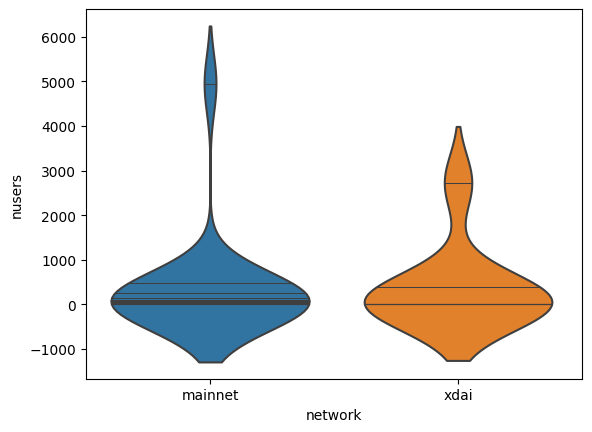

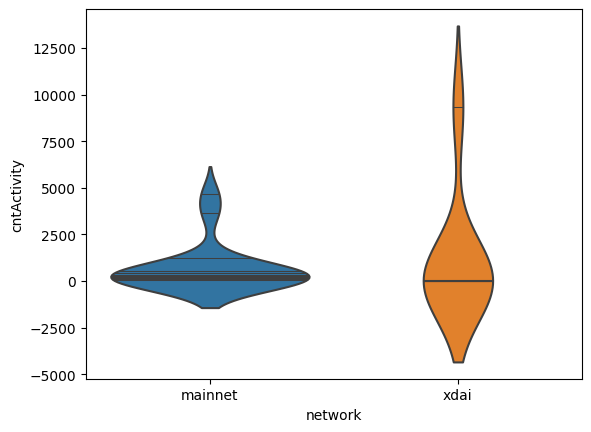

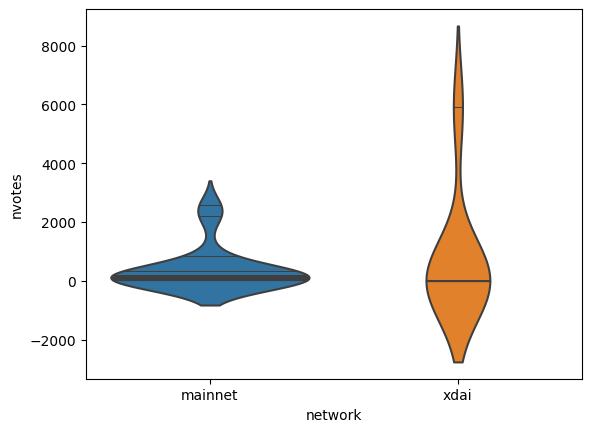

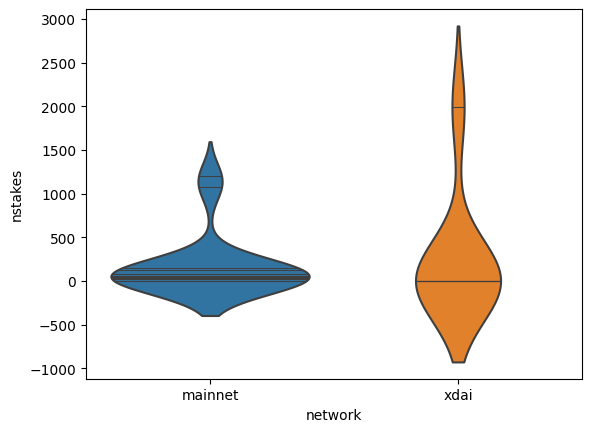

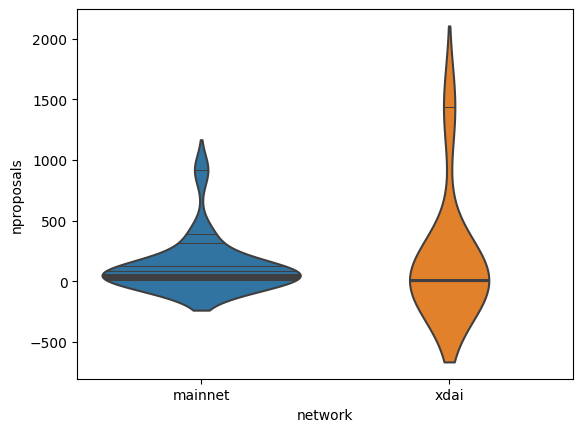

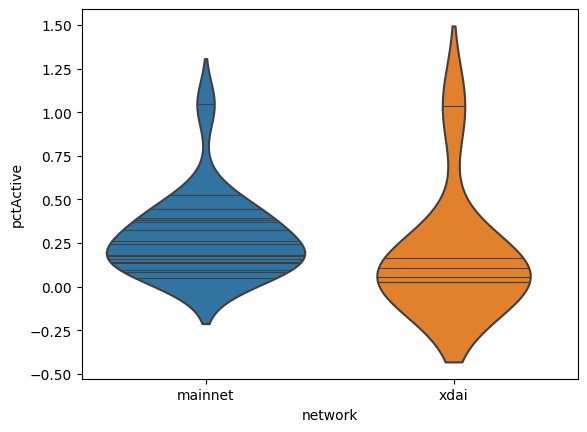

In [28]:
for c in WANTED_COLS:
    sns.violinplot(data=dfd_filtered.reset_index(), x='network', y=c, inner='stick')
    plt.show()

# Repetir datos generales por grupo

## ¿Cuantos grupos existen por red?

In [29]:
dfg = utils.get_df('dfg')
dfg.value_counts('network')

network
mainnet    15
xdai        7
mixed       1
dtype: int64

In [30]:
utils.get_df('dfgeq')[['nusers', 'nproposals', 'vp gini']].corr('spearman')

nusers  nproposals   vp gini
nusers      1.000000    0.733831  0.802084
nproposals  0.733831    1.000000  0.721206
vp gini     0.802084    0.721206  1.000000

In [31]:
utils.get_df('dfgeq')[dfg['nusers'] > 14].describe() #.sort_values('nusers')

daocnt       diff       nusers      hnusers   nproposals  \
count  12.000000  12.000000    12.000000    12.000000    12.000000   
mean    1.250000  20.166667   751.750000   760.833333   303.666667   
std     0.621582  12.371766  1524.817254  1536.543928   664.434460   
min     1.000000   1.000000    26.000000    26.000000    16.000000   
25%     1.000000  11.000000    45.750000    45.750000    34.000000   
50%     1.000000  19.000000    84.000000    84.500000    52.500000   
75%     1.000000  25.500000   342.750000   344.750000   161.250000   
max     3.000000  45.000000  4946.000000  4946.000000  2356.000000   

            nvotes     nvoters  nvoters_pct  nproposers  pctApproved  ...  \
count    12.000000   12.000000    12.000000   12.000000    12.000000  ...   
mean   1084.416667   42.666667     0.312423   39.583333     0.686543  ...   
std    2425.318028   57.736601     0.224981   58.006988     0.190328  ...   
min      22.000000    4.000000     0.001413    4.000000     0.267857  ...   
25%      67.500000   11.000000     0.163158    9.750000     0.648372  ...   
50%     134.500000   24.000000     0.329988   15.000000     0.739865  ...   
75%     503.750000   33.750000     0.436711   29.000000     0.783282  ...   
max    8479.000000  193.000000     0.764706  171.000000     0.904075  ...   

               FN  precision  precision_boosted  precision_nonboosted  \
count   12.000000  12.000000          11.000000             12.000000   
mean    31.333333   0.850859           0.944674              0.846801   
std     96.506555   0.247700           0.061331              0.287808   
min      0.000000   0.301230           0.833333              0.138107   
25%      0.000000   0.873317           0.916786              0.892731   
50%      0.000000   0.967931           0.961131              1.000000   
75%      5.500000   0.976614           0.993452              1.000000   
max    337.000000   1.000000           1.000000              1.000000   

       min_users_majority  min_users_majority_pct  min_users_90  \
count           12.000000               12.000000     12.000000   
mean            75.416667                0.190603    352.500000   
std            200.749712                0.156093   1003.580182   
min              4.000000                0.005654     12.000000   
25%              9.500000                0.085852     22.500000   
50%             17.000000                0.152957     44.000000   
75%             20.750000                0.264417    101.750000   
max            711.000000                0.479167   3534.000000   

       min_users_90_pct    vp gini       vp lac  
count         12.000000  12.000000    12.000000  
mean           0.524117   0.544008   568.939783  
std            0.297591   0.301410  1104.471204  
min            0.053710   0.041427     5.098849  
25%            0.305777   0.339402    40.550227  
50%            0.600848   0.576207    54.700275  
75%            0.758826   0.750916   262.096810  
max            0.895833   0.957258  3277.232666  

[8 rows x 26 columns]

In [32]:
dfg[dfg['nusers'] > 14].sort_values('nproposals')

daocnt       firstActivity        lastProposal  diff  \
group                                                                   
efxDAO                1 2019-06-13 20:37:38 2020-02-03 15:47:54   8.0   
ETHGlobal             1 2019-11-07 19:30:21 2019-12-07 00:40:40   1.0   
BuffiDAO              1 2020-02-06 18:29:00 2020-12-23 10:03:06  11.0   
PrimeDAO              1 2020-12-03 19:56:34 2022-05-28 10:54:49  18.0   
necDAO                1 2020-01-26 12:26:36 2023-02-20 14:05:47  37.0   
CuraDAO               1 2019-08-06 22:47:40 2021-08-18 06:44:29  25.0   
Kyber DAO Exp#2       1 2019-06-21 11:33:35 2020-04-30 15:33:06  11.0   
PolkaDAO              1 2019-05-27 14:39:45 2020-09-24 15:07:51  16.0   
FestDAO               1 2019-10-26 20:50:19 2021-05-27 07:12:25  20.0   
Genesis Alpha         1 2019-04-10 18:59:04 2021-02-16 06:36:36  23.0   
dOrg                  3 2019-05-20 21:29:40 2021-07-26 18:16:59  27.0   
dxDAO                 2 2019-07-14 12:08:13 2023-04-05 13:25:00  45.0   

                 network  nusers  hnusers  nproposals  nvotes  nvoters  ...  \
group                                                                   ...   
efxDAO           mainnet      26       26          16      48       11  ...   
ETHGlobal        mainnet      48       48          19      74       24  ...   
BuffiDAO            xdai    2730     2830          25      22        4  ...   
PrimeDAO         mainnet      95       95          37      30        5  ...   
necDAO           mainnet     140      140          43     137       39  ...   
CuraDAO          mainnet      55       55          49     103       11  ...   
Kyber DAO Exp#2  mainnet    4946     4946          56     208       32  ...   
PolkaDAO         mainnet      73       74          82     186       24  ...   
FestDAO          mainnet      39       39          86     132       15  ...   
Genesis Alpha    mainnet     266      268         387    2203      128  ...   
dOrg             mainnet      30       34         488    1391       26  ...   
dxDAO              mixed     573      575        2356    8479      193  ...   

                 pctBoosted       vpp       spp    TP   TN  FP   FN  \
group                                                                 
efxDAO             0.750000  3.000000  1.562500    12    4   0    0   
ETHGlobal          0.315789  3.894737  2.578947     5   11   1    2   
BuffiDAO           0.000000  0.880000  0.080000     0    9   0   16   
PrimeDAO           0.702703  0.810811  0.837838    26   10   0    1   
necDAO             0.767442  3.186047  1.209302    28   10   5    0   
CuraDAO            0.836735  2.102041  1.163265    39    8   2    0   
Kyber DAO Exp#2    0.303571  3.714286  1.357143    15   39   2    0   
PolkaDAO           0.792683  2.268293  1.841463    63   17   2    0   
FestDAO            0.779070  1.534884  1.395349    67   19   0    0   
Genesis Alpha      0.731266  5.692506  2.788114   272  104  11    0   
dOrg               0.198770  2.850410  0.290984    93   54   4  337   
dxDAO              0.907470  3.598896  1.353141  2110  198  28   20   

                 precision  precision_boosted  precision_nonboosted  
group                                                                
efxDAO            1.000000           1.000000              1.000000  
ETHGlobal         0.842105           0.833333              0.846154  
BuffiDAO          0.360000                NaN              0.360000  
PrimeDAO          0.972973           1.000000              0.909091  
necDAO            0.883721           0.848485              1.000000  
CuraDAO           0.959184           0.951220              1.000000  
Kyber DAO Exp#2   0.964286           0.882353              1.000000  
PolkaDAO          0.975610           0.969231              1.000000  
FestDAO           1.000000           1.000000              1.000000  
Genesis Alpha     0.971576           0.961131              1.000000  
dOrg              0.301230           0.958763       

In [33]:
_nusers = dfg[['daocnt', 'hnusers', 'nproposals']].copy().sort_values('hnusers')
# _nusers['hnusers_freq'] = _nusers.groupby('hnusers')['hnusers'].transform('count')
_nusers['hnusers_freq'] = 1
_nusers['hnusers_cumfreq'] = _nusers['hnusers_freq'].cumsum()
_nusers['hnusers_cumrfreq'] = _nusers['hnusers_cumfreq'] / _nusers['hnusers_freq'].sum()
_nusers['i_hnusers_cumrfreq'] = 1 - _nusers['hnusers_cumrfreq']
_nusers

daocnt  hnusers  nproposals  hnusers_freq  \
group                                                              
Pepo UX Awards DAO          1        4           2             1   
Lendroid Taleb              1        4           4             1   
3Box                        1        5           8             1   
DAOstack DAO                1        6          13             1   
DetroitDAO                  1        6          11             1   
QuorumDAO                   1        6           4             1   
Secret DAO                  1        7           6             1   
DAOfund                     1        8          49             1   
The General Store DAO       1       10          30             1   
CENNZnet Grants DAO         1       12          21             1   
1UP                         1       14          40             1   
efxDAO                      1       26          16             1   
dOrg                        3       34         488             1   
FestDAO                     1       39          86             1   
ETHGlobal                   1       48          19             1   
CuraDAO                     1       55          49             1   
PolkaDAO                    1       74          82             1   
PrimeDAO                    1       95          37             1   
necDAO                      1      140          43             1   
Genesis Alpha               1      268         387             1   
dxDAO                       2      575        2356             1   
BuffiDAO                    1     2830          25             1   
Kyber DAO Exp#2             1     4946          56             1   

                       hnusers_cumfreq  hnusers_cumrfreq  i_hnusers_cumrfreq  
group                                                                         
Pepo UX Awards DAO                   1          0.043478            0.956522  
Lendroid Taleb                       2          0.086957            0.913043  
3Box                                 3          0.130435            0.869565  
DAOstack DAO                         4          0.173913            0.826087  
DetroitDAO                           5          0.217391            0.782609  
QuorumDAO                            6          0.260870            0.739130  
Secret DAO                           7          0.304348            0.695652  
DAOfund                              8          0.347826            0.652174  
The General Store DAO                9          0.391304            0.608696  
CENNZnet Grants DAO                 10          0.434783            0.565217  
1UP                                 11          0.478261            0.521739  
efxDAO                              12          0.521739            0.478261  
dOrg                                13          0.565217            0.434783  
FestDAO                             14          0.608696            0.391304  
ETHGlobal                           15          0.652174            0.347826  
CuraDAO                             16          0.695652            0.304348  
PolkaDAO                            17          0.739130            0.260870  
PrimeDAO                            18          0.782609            0.217391  
necDAO                              19          0.826087            0.173913  
Genesis Alpha                       20          0.869565            0.130435  
dxDAO                               21          0.913043            0.086957  
BuffiDAO                            22          0.956522            0.043478  
Kyber DAO Exp#2                     23          1.000000            0.000000

In [34]:
x = (dfg['hnusers'] > 14)
print(f"{x.sum()}/{len(dfg)} = {x.mean()*100:.2f}%")

12/23 = 52.17%


## Tabla

In [35]:
DISPLAY_COLS = ['group', 'firstActivity', 'lastProposal', 'diff', 'nproposals', 'pctApproved', 'pctBoosted', 'hnusers', 'nvoters (pct)', 'nproposers (pct)', 'vpp', 'spp']
# , 'monthsWithActivity',

_table = utils.get_df('dfg').reset_index()
_table = _table.ds.add_pct_col('nvoters', 'hnusers').ds.add_pct_col('nproposers', 'hnusers')

_table = _table[['network'] + DISPLAY_COLS]

s = _table.style.apply(utils.tables.nameColorByNetwork, namecol='group', axis=None) \
    .hide(['network'], 'columns') \
    .hide(axis='index') \
    .format(lambda d:f'{d:.0f}', subset=['diff']) \
    .format(lambda d:d.strftime('%b \'%y') if not pd.isna(d) else d, subset=['firstActivity','lastProposal']) \
    .format(lambda d:f'{d*100:.2g}%', subset=['pctApproved', 'pctBoosted']) \
    .format(lambda d:f'{d:.0f}', subset=['hnusers']) \
    .format(lambda d:f'{d:.2g}', subset=['vpp', 'spp'])

# utils.tables.save_table_image(s, "DAOs/resumen_group.png", debug=True)
s

In [36]:
print("Total:", len(dfg))
dfg['network'].value_counts()

Total: 23


mainnet    15
xdai        7
mixed       1
Name: network, dtype: int64

In [37]:
dfg[dfg['hnusers'] > 10]['nvoters_pct'].median()

0.3299882491186839

In [38]:
_table = dfg[dfg['hnusers'] > 20].reset_index()
_table = _table.ds.add_pct_col('nvoters', 'hnusers').ds.add_pct_col('nproposers', 'hnusers')
_table = _table[['network'] + DISPLAY_COLS]

s = _table.style.apply(utils.tables.nameColorByNetwork, namecol='group', axis=None) \
    .hide(['network'], 'columns') \
    .hide(axis='index') \
    .format(lambda d:f'{d:.0f}', subset=['diff']) \
    .format(lambda d:d.strftime('%b \'%y') if not pd.isna(d) else d, subset=['firstActivity','lastProposal']) \
    .format(lambda d:f'{d*100:.2g}%', subset=['pctApproved', 'pctBoosted']) \
    .format(lambda d:f'{d:.0f}', subset=['hnusers']) \
    .format(lambda d:f'{d:.2g}', subset=['vpp', 'spp'])

s

## Tabla resumen resumen

In [39]:
WANTED_COLS = ['nusers', 'cntActivity', 'nvotes', 'nstakes', 'nproposals', 'pctActive', 'monthsWithActivity']

dfg.describe(percentiles=[.25,.50,.75,.85,.90,.95]).transpose()

count        mean          std       min        25%  \
daocnt                 23.0    1.130435     0.457697  1.000000   1.000000   
diff                   23.0   13.217391    12.202669  1.000000   3.500000   
nusers                 23.0  395.695652  1143.295573  4.000000   6.000000   
hnusers                23.0  400.521739  1152.628611  4.000000   6.500000   
nproposals             23.0  166.608696   492.216207  2.000000  12.000000   
nvotes                 23.0  577.608696  1798.382069  3.000000  18.500000   
nvoters                23.0   24.304348    45.308473  3.000000   3.500000   
nvoters_pct            23.0    0.450943     0.244564  0.001413   0.305019   
nproposers             23.0   22.608696    44.971445  0.000000   2.000000   
pctApproved            23.0    0.701468     0.210377  0.153846   0.645581   
pctBoosted             23.0    0.405492     0.365891  0.000000   0.000000   
vpp                    23.0    2.335394     1.194087  0.810811   1.464286   
spp                    23.0    0.898247     0.851265  0.000000   0.040000   
TP                     23.0  121.739130   437.305928  0.000000   0.000000   
TN                     23.0   22.913043    44.663299  0.000000   2.500000   
FP                     23.0    2.608696     6.080813  0.000000   0.000000   
FN                     23.0   19.347826    69.604473  0.000000   0.000000   
precision              23.0    0.665946     0.352019  0.000000   0.367500   
precision_boosted      15.0    0.935018     0.068782  0.800000   0.875959   
precision_nonboosted   23.0    0.646336     0.384698  0.000000   0.305000   

                            50%         75%         85%          90%  \
daocnt                 1.000000    1.000000    1.000000     1.000000   
diff                  10.000000   21.000000   24.400000    26.600000   
nusers                26.000000   84.000000  228.200000   511.600000   
hnusers               26.000000   84.500000  229.600000   513.600000   
nproposals            30.000000   52.500000   84.800000   326.800000   
nvotes                48.000000  134.500000  201.400000  1154.400000   
nvoters                7.000000   24.000000   30.200000    37.600000   
nvoters_pct            0.477612    0.633333    0.725000     0.750000   
nproposers             9.000000   15.500000   24.900000    33.400000   
pctApproved            0.750000    0.855442    0.897197     0.904624   
pctBoosted             0.315789    0.758721    0.788599     0.827924   
vpp                    2.102041    3.000000    3.475041     3.691208   
spp                    0.837838    1.376246    1.668750     1.816028   
TP                    15.000000   33.500000   65.800000    87.800000   
TN                     9.000000   14.500000   33.000000    51.000000   
FP                     0.000000    2.000000    3.700000     4.800000   
FN                     2.000000    7.500000   16.000000    19.200000   
precision              0.846154    0.973986    0.978421     0.995925   
precision_boosted      0.961131    0.993452    1.000000     1.000000   
precision_nonboosted   0.846154    1.000000    1.000000     1.000000   

                              95%          max  
daocnt                   1.900000     3.000000  
diff                    36.000000    45.000000  
nusers                2514.300000  4946.000000  
hnusers               2604.500000  4946.000000  
nproposals             477.900000  2356.000000  
nvotes                2121.800000  8479.000000  
nvoters                119.100000   193.000000  
nvoters_pct              0.763235     0.875000  
nproposers             141.200000   171.000000  
pctApproved              0.908658     1.000000  
pctBoosted               0.897959     0.907470  
vpp                      3.876692     5.692506  
spp                      2.505199     2.788114  
TP                     254.100000  2110.000000  
TN                      99.000000   198.000000  
FP                      10.400000    28.000000  
FN                      22.700000   337.000000  
precision

# DAOs concretas

## dOrg

In [40]:
dfdna = utils.get_df('dfd', registered_only=False)

dfdd = dfdna[dfdna['name'] == 'dOrg']
dfdd

id  \
network dao                                                                                      
mainnet 0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6  0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526  0xbe1a98d3452f6da6e0984589e545d4fc25af7526   
        0xd358d4f159e6fae32d1b6096bdace829a5fe33fb  0xd358d4f159e6fae32d1b6096bdace829a5fe33fb   
        0xdc91dddc3027b1b69cd9a583ac6625577b942ff1  0xdc91dddc3027b1b69cd9a583ac6625577b942ff1   

                                                    name      register  \
network dao                                                              
mainnet 0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6  dOrg    registered   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526  dOrg  unRegistered   
        0xd358d4f159e6fae32d1b6096bdace829a5fe33fb  dOrg  unRegistered   
        0xdc91dddc3027b1b69cd9a583ac6625577b942ff1  dOrg            na   

                                                                                   nativeToken  \
network dao                                                                                      
mainnet 0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6  0x3b2d0c1b652d5fad3a43f4ada7265371eac050d4   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526  0xa2952b15d34d40c9bcd6596a06f9cbb0561236f0   
        0xd358d4f159e6fae32d1b6096bdace829a5fe33fb  0xf3cf5bddbf4cb8dccdce776bbb217432c617a314   
        0xdc91dddc3027b1b69cd9a583ac6625577b942ff1  0x6ab3a6aad11998a2849963658c3ad6a811600d4c   

                                                                              nativeReputation  \
network dao                                                                                      
mainnet 0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6  0x53757c07fa372d1ac873c701dccfd1ebcc563e0e   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526  0xe0a46b46b9f283285b2461b73ebb027eef39883d   
        0xd358d4f159e6fae32d1b6096bdace829a5fe33fb  0x7e4230d68ea22730ec1ae13173c333c452424e58   
        0xdc91dddc3027b1b69cd9a583ac6625577b942ff1  0x40f9245b19efdf00df2aeca64c3ebb79ea647a53   

                                                    nusers  hnusers  \
network dao                                                           
mainnet 0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6      29     31.0   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526      21     25.0   
        0xd358d4f159e6fae32d1b6096bdace829a5fe33fb      21     22.0   
        0xdc91dddc3027b1b69cd9a583ac6625577b942ff1      21     22.0   

                                                             firstUser  \
network dao                                                              
mainnet 0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6 2020-03-06 05:32:31   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526 2019-05-10 01:45:49   
        0xd358d4f159e6fae32d1b6096bdace829a5fe33fb 2020-02-12 20:38:05   
        0xdc91dddc3027b1b69cd9a583ac6625577b942ff1 2020-02-12 00:33:04   

                                                         firstActivity  \
network dao                                                              
mainnet 0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6 2020-03-06 15:53:30   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526 2019-05-20 21:29:40   
        0xd358d4f159e6fae32d1b6096bdace829a5fe33fb 2020-02-12 21:09:34   
        0xdc91dddc3027b1b69cd9a583ac6625577b942ff1 2020-05-22 23:43:54   

                                                          lastActivity  ...  \
network dao                                                             ...   
mainnet 0x15344ecdc2c4edfcb092e284d93c20f0529fd8a6 2021-07-27 11:16:02  ...   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526 2020-05-22 23:53:42  ...   
        0xd358d4f159e6fae32d1b6096bdace829a5fe33fb 2020-05-22 23:53:42  ...   
        0xdc91dddc3027b1b69cd9a583ac6625577b942ff1 2020-05-22 23:53:42  ...   

                                                      TN   FP     FN  \
network dao     

## KyberDAO

In [41]:
dfd = utils.get_df('dfd').reset_index()

dfdk = dfd[dfd['name'] == 'Kyber DAO Exp#2']
dfdk

network                                         dao  \
14  mainnet  0x6bee9b81e434f7afce72a43a4016719315069539   

                                            id             name    register  \
14  0x6bee9b81e434f7afce72a43a4016719315069539  Kyber DAO Exp#2  registered   

                                   nativeToken  \
14  0x7a334d5ba02490aa7be1307d235a4b021f8574be   

                              nativeReputation  nusers  hnusers  \
14  0xed1c0bb038b370a16242f077899ee1e5e7d6add1    4946   4946.0   

             firstUser  ...    TN   FP   FN  precision  precision_boosted  \
14 2019-06-20 12:20:57  ...  39.0  2.0  0.0   0.964286           0.882353   

    precision_nonboosted  nvoters  nproposers     shortid            group  
14                   1.0     32.0        17.0  1810799489  Kyber DAO Exp#2  

[1 rows x 39 columns]

## BuffiDAO

Se creó para el hackathlon de ETHDenver 2020

In [42]:
buffidao = dfd[(dfd['name'] == 'BuffiDAO') & (dfd['register'] == 'registered') & (dfd['network'] == 'xdai')].iloc[0]
buffidao

network                                                          xdai
dao                        0xe248a76a4a84667c859eb51b9af6dea29e52f139
id                         0xe248a76a4a84667c859eb51b9af6dea29e52f139
name                                                         BuffiDAO
register                                                   registered
nativeToken                0x96c993b81425920466fc8401ae40e82159138640
nativeReputation           0x7905f89e877e16822c46fe7509bb61a6e0ae3af1
nusers                                                           2730
hnusers                                                        2830.0
firstUser                                         2020-02-06 15:05:15
firstActivity                                     2020-02-06 18:29:00
lastActivity                                      2020-02-16 21:18:35
lastVote                                          2020-02-16 21:18:35
cntActivity                                                        44
nvotes              

### ¿Qué días concretos ha tenido actividad?

From 2020-02-06 18:29:00 to 2020-02-16 21:18:35


<Axes: title={'center': 'Cantidad acumulada de actividad en BuffiDAO'}, xlabel='at'>

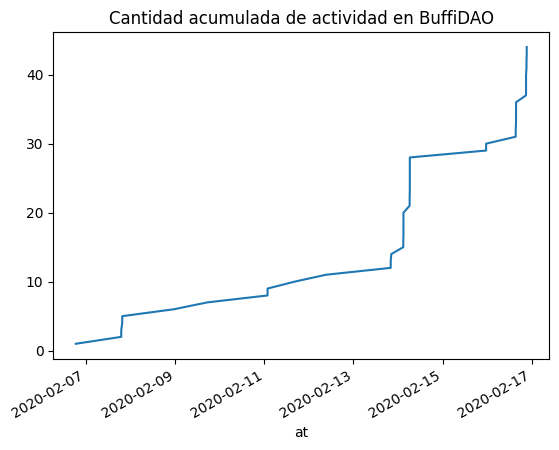

In [43]:
dfab = utils.get_df('dfa')
dfab = dfab[dfab['dao'] == buffidao['dao']]
dfab = dfab.sort_values('at')
dfab['cnt'] = 1
dfab['cumcnt'] = dfab['cnt'].cumsum()
start = dfab['at'].min()
end = dfab['at'].max()

print("From", start, "to", end)
dfab.set_index('at')['cumcnt'].plot(title='Cantidad acumulada de actividad en BuffiDAO')

### ¿Cuánta gente ha hecho algo en realidad?

In [44]:
dfab['user'].nunique()

7

## dxDAO

In [45]:
# Mostrar direcciones de dxdao
dfdx = dfd[dfd['name'].str.lower().str.contains('dxdao')]
dfdx

network                                         dao  \
9   mainnet  0x519b70055af55a007110b4ff99b0ea33071c720a   
82     xdai  0xe716ec63c5673b3a4732d22909b38d779fa47c3f   

                                            id    name    register  \
9   0x519b70055af55a007110b4ff99b0ea33071c720a   dxDAO  registered   
82  0xe716ec63c5673b3a4732d22909b38d779fa47c3f  xDXdao  registered   

                                   nativeToken  \
9   0x643b14f6ea235668278da5974930105852f2b7c4   
82  0xf255b9d83db924820ee23a7dcc30b7542e201bb1   

                              nativeReputation  nusers  hnusers  \
9   0x7a927a93f221976aae26d5d077477307170f0b7c     488    489.0   
82  0xed77eaa9590cfce0a126bab3d8a6ada9a393d4f6     401    402.0   

             firstUser  ...     TN    FP    FN  precision  precision_boosted  \
9  2019-06-28 12:14:30  ...  118.0  10.0   1.0   0.988017           0.987484   
82 2020-11-17 08:45:40  ...   80.0  18.0  19.0   0.974270           0.986557   

    precision_nonboosted  nvoters  nproposers     shortid  group  
9               0.991597    134.0       102.0  1369141253  dxDAO  
82              0.808081     92.0        97.0  3877039203  dxDAO  

[2 rows x 39 columns]

### ¿Se comporta igual en mainnet que xdai?

In [46]:
DXDAO_ADDR = "0x519b70055af55a007110b4ff99b0ea33071c720a"
XDXDAO_ADDR = "0xe716ec63c5673b3a4732d22909b38d779fa47c3f"

#### Precisión

In [47]:
dfpr = utils.get_df('dfpr')
dfprx = dfpr[dfpr['dao'].isin(dfdx['dao'])].copy()
dfprx

network                                                 id  \
2     mainnet  0x003c109411e96e5607ce609278536262e12afdaa65ab...   
5     mainnet  0x00a6fff3bc39d362f1153029f9105ea14c080ebbf475...   
9     mainnet  0x010c938f9cd050e3e3112fc1241a62583dec1ad09b9a...   
10    mainnet  0x011f8609171d99705dda26d2d82cdcc691cdf8916997...   
11    mainnet  0x01307fd72aa360c5c2964867c47ef46afd3fa4c83a94...   
...       ...                                                ...   
3796     xdai  0xfeb2d79cd1e17a3e3f1b22b15a3b86d6284a1415dea8...   
3797     xdai  0xfeea9d463a997be8e640ecfdc7b8179e7424ebe8c0d8...   
3798     xdai  0xff32174f3f2ff80955d5075937f72d07f5bc18364946...   
3800     xdai  0xff6c045d9ab8f514b7dce6317ac1ff16786cad69bd4a...   
3801     xdai  0xffc0f4a64c8ec043238ca787e58177c2e798360c2989...   

                                        proposer     stage  \
2     0xb33b9fba681653fe263b31a95766d83d18c2128d  Executed   
5     0xd97672177e0673227fa102c91bfa8b8cfa825141  Executed   
9     0x91628ddc3a6ff9b48a2f34fc315d243eb07a9501  Executed   
10    0x3111327edd38890c3fe564afd96b4c73e8101747  Executed   
11    0xe1d2210a967ee144aad31ecd08565e894b88ffaf  Executed   
...                                          ...       ...   
3796  0x8e900cf9bd655e34bb610f0ef365d8d476fd7337  Executed   
3797  0x3111327edd38890c3fe564afd96b4c73e8101747  Executed   
3798  0x91628ddc3a6ff9b48a2f34fc315d243eb07a9501  Executed   
3800  0x8e900cf9bd655e34bb610f0ef365d8d476fd7337  Executed   
3801  0xa601aed34dda12ff760d8abb64fd4eb3664e35af  Executed   

               createdAt        preBoostedAt           boostedAt  \
2    2020-03-14 17:52:32 2020-03-14 19:53:49 2020-03-15 19:54:03   
5    2021-08-15 11:51:26 2021-08-15 12:15:10 2021-08-16 12:53:54   
9    2023-01-09 23:26:59 2023-01-10 10:00:23 2023-01-12 23:15:35   
10   2020-09-30 16:12:28 2020-09-30 16:15:12 2020-10-01 16:15:13   
11   2021-07-09 16:59:41 2021-07-09 17:08:04 2021-07-10 17:17:22   
...                  ...                 ...                 ...   
3796 2022-03-09 14:37:55 2022-03-09 14:41:00 2022-03-10 16:57:35   
3797 2021-06-05 20:01:15 2021-06-10 07:29:40 2021-06-11 07:29:55   
3798 2021-06-04 03:27:55 2021-06-10 00:00:55 2021-06-11 00:01:15   
3800 2022-02-08 09:23:30 2022-02-08 09:27:40 2022-02-09 10:51:15   
3801 2021-01-22 19:09:15 2021-01-22 21:10:40 2021-01-23 21:10:55   

     quietEndingPeriodBeganAt            closingAt preBoostedClosingAt  ...  \
2                         NaT  3752-09-25 14:56:40 2020-03-15 19:53:49  ...   
5                         NaT  3609-02-20 05:36:40 2021-08-16 12:15:10  ...   
9         2023-01-25 13:51:11  2022-01-31 18:53:27 2023-01-12 10:00:23  ...   
10                        NaT  3698-01-06 18:51:40 2020-10-01 16:15:12  ...   
11                        NaT  3620-10-17 18:40:00 2021-07-10 17:08:04  ...   
...                       ...                  ...                 ...  ...   
3796                      NaT  3555-02-03 19:51:40 2022-03-10 14:41:00  ...   
3797                      NaT  3629-09-02 07:31:40 2021-06-11 07:29:40  ...   
3798                      NaT  3629-10-03 11:10:00 2021-06-11 00:00:55  ...   
3800                      NaT  3563-02-07 06:41:40 2022-02-09 09:27:40  ...   
3801                      NaT  2020-01-23 13:17:40 2021-01-23 21:10:40  ...   

     createdAtMonth daoRegister nvoters daostake nstakers internalDAO  \
2           2020-03  registered       5    250.0      2.0         1.0   
5           2021-08  registered       1    250.0      1.0         1.0   
9           2023-01  registered       1    250.0      2.0         2.0   
10          2020-09  registered       6    250.0      2.0         2.0   
11          2021-07  registered       2    250.0      2.0         2.0   
...             ...         ...     ...      ...      ...         ...   
3796        2022-03  registered       4    200.0      1.0         0.0   
3797        2021-06  registered       6    200.0      2.0         2.0   
3798        2021-06  

y_true = approved, y_pred = boosted
              precision    recall  f1-score   support

       False       0.89      0.86      0.88       192
        True       0.99      0.99      0.99      2125

    accuracy                           0.98      2317
   macro avg       0.94      0.93      0.93      2317
weighted avg       0.98      0.98      0.98      2317

## mainnet only ##
              precision    recall  f1-score   support

       False       0.99      0.92      0.95       111
        True       0.99      1.00      0.99       790

    accuracy                           0.99       901
   macro avg       0.99      0.96      0.97       901
weighted avg       0.99      0.99      0.99       901

## xdai only ##
              precision    recall  f1-score   support

       False       0.77      0.79      0.78        81
        True       0.99      0.99      0.99      1335

    accuracy                           0.97      1416
   macro avg       0.88      0.89      0.88      1416
wei

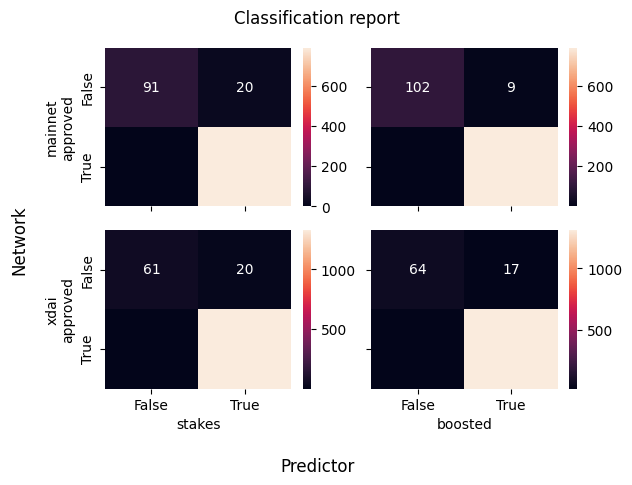

In [48]:
utils.plot.classification_report_2x2(dfprx)

#### Participación

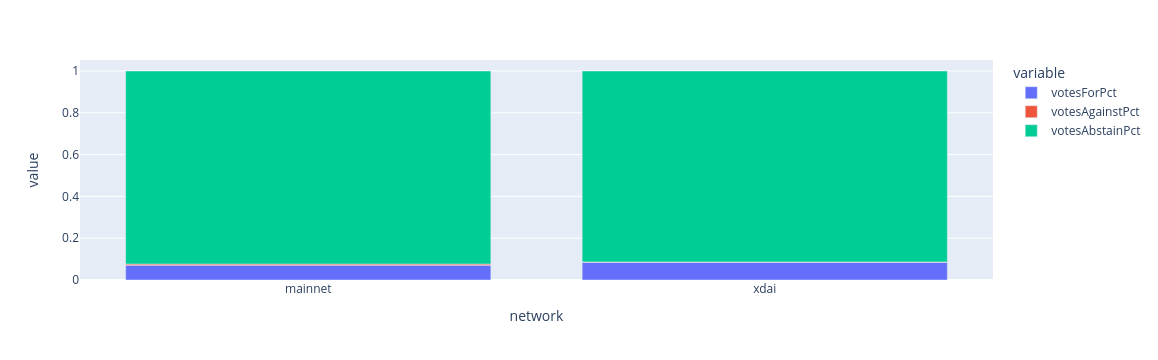

In [49]:
dfprx['votesForPct'] = dfprx['votesFor'].astype(float) / dfprx['totalRepWhenExecuted'].astype(float)
dfprx['votesAgainstPct'] = dfprx['votesAgainst'].astype(float) / dfprx['totalRepWhenExecuted'].astype(float)
dfprx['votesAbstainPct'] = 1 - dfprx['votesForPct'] - dfprx['votesAgainstPct']

_toplot = dfprx[['network', 'votesForPct', 'votesAgainstPct', 'votesAbstainPct']]
px.bar(_toplot.groupby('network').mean().reset_index(), x='network', y=['votesForPct', 'votesAgainstPct', 'votesAbstainPct'])

#### Staking

Amount staked

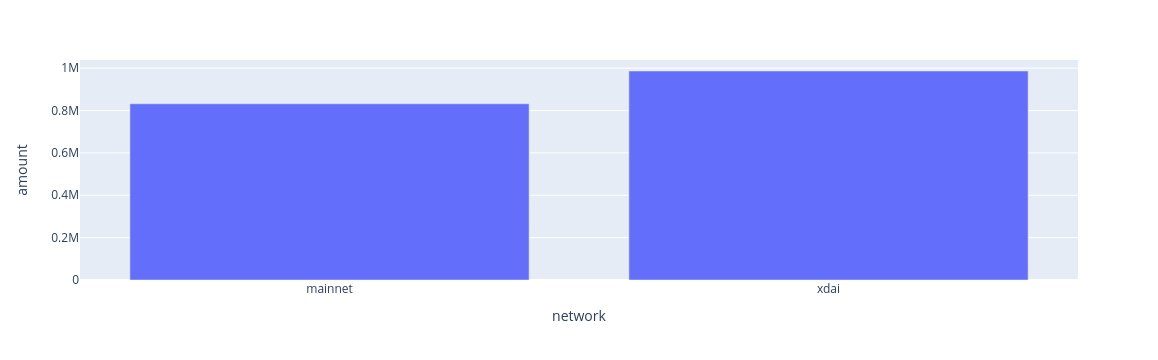

In [50]:
dfs = utils.get_df('dfs')
dfsx = dfs[dfs.dao.isin(dfdx.dao)].copy()

px.bar(dfsx.groupby('network')['amount'].sum().reset_index(), x='network', y='amount')

In [51]:
dfsx.groupby('network')['amount'].mean().reset_index()

network      amount
0  mainnet  715.957917
1     xdai  763.653413

### Porcentaje de usuarios en común

In [52]:
dfh = utils.get_df('dfh')
dfh_dxdao = dfh[dfh['dao'] == DXDAO_ADDR]['address']
dfh_xdxdao = dfh[dfh['dao'] == XDXDAO_ADDR]['address']

mainnet_in_xdai = dfh_dxdao.isin(dfh_xdxdao).sum()
mainnet_total = dfh_dxdao.count()
xdai_in_mainnet = dfh_xdxdao.isin(dfh_dxdao).sum()
xdai_total = dfh_xdxdao.count()

mainnet_in_xdai, mainnet_total, xdai_in_mainnet, xdai_total

(316, 488, 316, 401)

### Últimas propuestas

In [53]:
dfp = utils.get_df('dfp')
dfp[dfp['group'] == 'dxDAO'].reset_index().sort_values('createdAt').tail(30)[['network', 'createdAt', 'boostedAt', 'winningOutcome', 'votesForPct', 'votesAgainstPct', 'nvoters', 'title', 'description']]

network           createdAt           boostedAt winningOutcome  \
218   mainnet 2023-01-25 14:57:47 2023-02-04 16:21:11           Pass   
228   mainnet 2023-01-25 15:01:23 2023-02-06 22:16:47           Pass   
641   mainnet 2023-01-26 11:11:23 2023-01-28 13:40:59           Pass   
589   mainnet 2023-01-29 12:33:47 2023-02-04 16:21:11           Pass   
702   mainnet 2023-02-01 12:22:35 2023-02-02 12:48:11           Pass   
756   mainnet 2023-02-01 13:40:47 2023-02-09 05:25:35           Pass   
1182     xdai 2023-02-02 18:17:55 2023-02-03 19:26:35           Pass   
2235     xdai 2023-02-02 18:23:30 2023-02-03 22:23:55           Pass   
949      xdai 2023-02-02 18:27:20 2023-02-04 15:57:35           Pass   
659   mainnet 2023-02-04 09:07:47 2023-02-07 14:23:11           Pass   
2123     xdai 2023-02-06 18:38:05 2023-02-08 20:20:15           Pass   
7     mainnet 2023-02-07 03:57:47                 NaT           Fail   
2220     xdai 2023-02-07 09:33:50 2023-02-08 10:33:50           Pass   
469   mainnet 2023-02-15 07:25:11 2023-02-18 15:25:23           Pass   
1718     xdai 2023-02-16 20:04:20 2023-02-17 22:30:00           Pass   
1125     xdai 2023-02-16 20:16:15 2023-02-20 15:24:35           Pass   
520   mainnet 2023-02-22 04:36:35 2023-02-24 17:28:59           Fail   
130   mainnet 2023-02-22 04:55:35 2023-02-24 17:28:59           Pass   
749   mainnet 2023-02-22 11:03:35 2023-02-25 06:45:35           Pass   
377   mainnet 2023-02-27 20:41:47 2023-03-02 00:42:23           Pass   
390   mainnet 2023-03-02 09:49:35 2023-03-03 20:26:11           Pass   
634   mainnet 2023-03-03 14:57:59 2023-03-05 21:37:47           Pass   
260   mainnet 2023-03-03 15:19:59 2023-03-07 03:43:23           Pass   
198   mainnet 2023-03-08 15:25:11 2023-03-11 19:00:11           Pass   
154   mainnet 2023-03-13 19:20:35 2023-03-16 12:51:35           Pass   
560   mainnet 2023-03-21 01:39:59 2023-03-24 15:59:47           Fail   
825   mainnet 2023-03-22 18:03:35                 NaT           Fail   
613   mainnet 2023-03-28 09:14:11 2023-03-29 13:15:11           Pass   
48    mainnet 2023-04-05 13:21:11 2023-04-07 15:36:11           Pass   
1116     xdai 2023-04-05 13:25:00 2023-04-07 09:34:55           Pass   

     votesForPct votesAgainstPct  nvoters  \
218       0.0612             0.0        2   
228     0.039512             0.0        2   
641     0.038801             0.0        1   
589       0.0385             0.0        1   
702       0.0617             0.0        2   
756     0.030856             0.0        2   
1182    0.033307             0.0        1   
2235    0.033307             0.0        1   
949     0.033307             0.0        1   
659     0.038751             0.0        1   
2123      0.0333             0.0        1   
7            0.0          0.0226        1   
2220    0.045714             0.0        2   
469     0.038879             0.0        1   
1718    0.033576             0.0        1   
1125    0.033576             0.0        1   
520          0.0             0.0        0   
130       0.0388             0.0        1   
749     0.015152             0.0        1   
377     0.039045             0.0        1   
390     0.015118             0.0        1   
634     0.038975             0.0        1   
260       0.0389             0.0        1   
198        0.038             0.0        1   
154     0.037375             0.0        1   
560          0.0             0.0        0   
825          0.0             0.0        0   
613     0.014509             0.0        1   
48      0.517512             0.0       28   
1116    0.127861             0.0       10   

                                                  title  \
218               DXgov Guild 2023 Q1 Funding - Stipend   
228    DXgov Guild 2023 Q1 Funding - Smart contract ...   
641         CowSwap Liquidity Order bea0a7e4 WETH / DXD   
589      Request return of DXD sent to DXdao by mistake   
702                 February 2023 tokens claim - Nathan   
756    DXgov Guild 2023

## FestDAO

In [54]:
festDAO = dfd[dfd['name'] == 'FestDAO'].iloc[0]
ADDR_FESTDAO = festDAO['id']
festDAO

network                                                       mainnet
dao                        0x8990e11b69403ea53ef2b32434bbd7dbf84b5234
id                         0x8990e11b69403ea53ef2b32434bbd7dbf84b5234
name                                                          FestDAO
register                                                   registered
nativeToken                0x11ea60aaf6b5fbe00e7dc5f0b336ed61d29b7d2c
nativeReputation           0xcc6d1b8f2f0a1d48fbd3adba991a0b0ef8a342a2
nusers                                                             39
hnusers                                                          39.0
firstUser                                         2019-10-17 20:37:36
firstActivity                                     2019-10-26 20:50:19
lastActivity                                      2021-05-27 22:33:58
lastVote                                          2021-05-27 22:33:58
cntActivity                                                       338
nvotes              

## Activity

saving to ../logseq/assets/nb_figures/DAOs/FestDAO/activity.png
Use ![Actividad mensual de FestDAO](../assets/nb_figures/DAOs/FestDAO/activity.png) to embed it in logseq


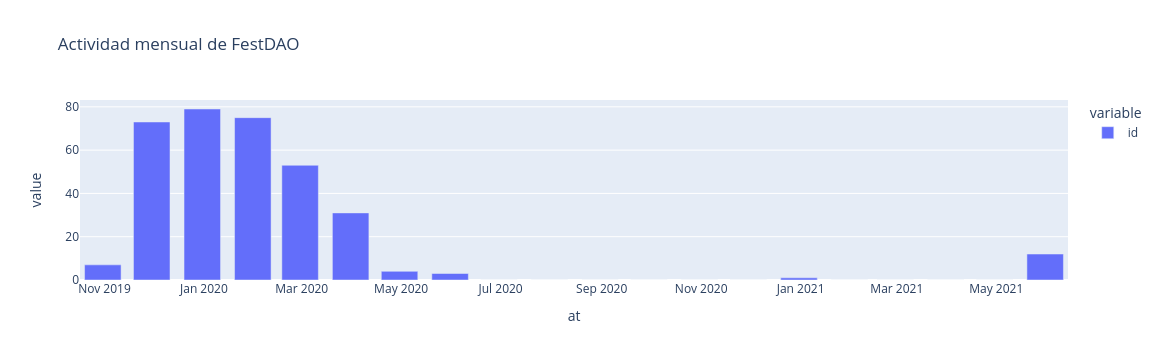

In [55]:
_toplot = dfact[dfact.dao == ADDR_FESTDAO]
# px.line(_toplot.set_index('at').sort_index().rolling('30d')['id'].count(), title='Actividad en los últimos 30d en FestDAO')
utils.plot.save_fig(px.bar(_toplot.set_index('at').groupby(pd.Grouper(freq='M'))['id'].count(), title='Actividad mensual de FestDAO'), 'DAOs/FestDAO/activity.png', show_title=True, showlegend=False)

## CennZnet 

In [56]:
cennZNET = dfd[dfd['name'].str.contains('CENNZnet')].iloc[0]
ADDR_CENNZNET = cennZNET['id']
cennZNET

network                                                       mainnet
dao                        0xee7fa430a7e513d3df962ed0c0e285bc6f87fc24
id                         0xee7fa430a7e513d3df962ed0c0e285bc6f87fc24
name                                              CENNZnet Grants DAO
register                                                   registered
nativeToken                0x340b166e566616c2726a28e806f0c75ca1b3331e
nativeReputation           0x0308d38c5c8ca382eddbc48403fb0fa3fd9c0c2f
nusers                                                             12
hnusers                                                          12.0
firstUser                                         2020-04-06 14:07:38
firstActivity                                     2020-04-20 11:00:14
lastActivity                                      2020-08-19 20:25:36
lastVote                                          2020-08-19 20:07:44
cntActivity                                                        87
nvotes              

saving to ../logseq/assets/nb_figures/DAOs/CENNZnet/activity.png
Use ![Actividad mensual de CENNZnet](../assets/nb_figures/DAOs/CENNZnet/activity.png) to embed it in logseq


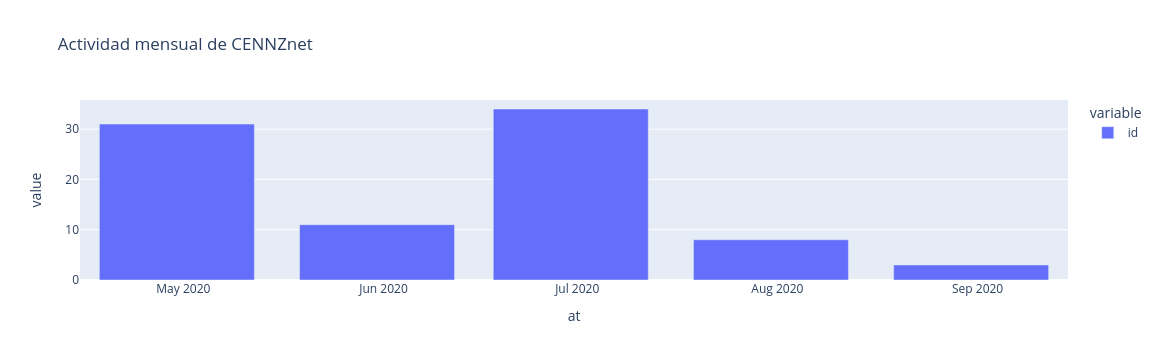

In [57]:
_toplot = dfact[dfact.dao == ADDR_CENNZNET]
# px.line(_toplot.set_index('at').sort_index().rolling('30d')['id'].count(), title='Actividad en los últimos 30d en FestDAO')
utils.plot.save_fig(px.bar(_toplot.set_index('at').groupby(pd.Grouper(freq='M'))['id'].count(), title='Actividad mensual de CENNZnet'), 'DAOs/CENNZnet/activity.png', show_title=True, showlegend=False)

## DAOstack DAO (xdai)

In [58]:
dfp = utils.get_df('dfp')
dfp = dfp[dfp['name'] == 'DAOstack DAO'].sort_values('createdAt')
print(dfp.columns)
print("There are", len(dfp), "proposals")
print(dfp.iloc[0]['description'])
print("------------------------")
print(dfp.iloc[1]['description'])
dfp[['proposer', 'createdAt', 'url', 'title', 'description']]

Index(['proposer', 'stage', 'createdAt', 'preBoostedAt', 'boostedAt',
       'quietEndingPeriodBeganAt', 'closingAt', 'preBoostedClosingAt',
       'executedAt', 'totalRepWhenExecuted', 'totalRepWhenCreated',
       'executionState', 'expiresInQueueAt', 'votesFor', 'votesAgainst',
       'winningOutcome', 'stakesFor', 'stakesAgainst', 'title', 'description',
       'url', 'confidence', 'confidenceThreshold',
       'queuedVoteRequiredPercentage', 'queuedVotePeriodLimit',
       'boostedVotePeriodLimit', 'thresholdConst', 'minimumDaoBounty',
       'daoBountyConst', 'dao', 'competitionId', 'name', 'group',
       'originalName', 'votesForPct', 'votesAgainstPct', 'executedAtMonth',
       'createdAtMonth', 'daoRegister', 'nvoters', 'daostake', 'nstakers',
       'internalDAO', 'isProposer'],
      dtype='object')
There are 13 proposals
Our main bounty at ETHDenver this year is for new DAO features and the use-cases they go with. Using our stack, build a new DAO feature, like a way for DA

proposer  \
network id                                                                                              
xdai    0xf63cf8f8bf3189382324036931272a1d3c54ba6a6b29...  0x478f1a09bc1477148a91508b9320274dce563605   
        0x009c5621081183ef288b439a2dd845d0bf1cacc581ee...  0x478f1a09bc1477148a91508b9320274dce563605   
        0x4cf3c86dea26f3207d9d9bb26f07712641f36575ef0e...  0x0084fb1d84f2359cafd00f92b901c121521d6809   
        0x3eb7caceaba98a6b4085a989adf81efedd257c26899e...  0x0084fb1d84f2359cafd00f92b901c121521d6809   
        0xec050369a62a0480cef35b306fa9804cacbbec271ffd...  0x3a5b03190ac4c01801bbc53ce014b48507adb7fd   
        0x4fb194de98fbfcc733ff9fb95985e05be0ffaf4fc704...  0xd377b7a9e76fc735ad1a579254ac7dd35f8978dc   
        0x0ffd54213b61cb24e464a1830a0aa3157282854eb1a2...  0xd377b7a9e76fc735ad1a579254ac7dd35f8978dc   
        0x1d478fe1521b3bdd18a86dede713e55259aa0c4b1de2...  0xd377b7a9e76fc735ad1a579254ac7dd35f8978dc   
        0x575a80d3672a842aaa6beac626c4e0f37851a3895036...  0x4171160db0e7e2c75a4973b7523b437c010dd9d4   
        0x80a5bad00ec06fad250a972cf0ea4fac192b5a6693fe...  0x4171160db0e7e2c75a4973b7523b437c010dd9d4   
        0x294b466d8596b6e5d4b1a1e9e31ccb2675edcad29bb8...  0x4171160db0e7e2c75a4973b7523b437c010dd9d4   
        0x4c81a3a32880832cb358b96a0995bb7e89a9fc500cd0...  0x4171160db0e7e2c75a4973b7523b437c010dd9d4   
        0x33aa6a03bca1d0adeb89b06b1e2d7567a44108e92e60...  0x4171160db0e7e2c75a4973b7523b437c010dd9d4   

                                                                    createdAt  \
network id                                                                      
xdai    0xf63cf8f8bf3189382324036931272a1d3c54ba6a6b29... 2020-02-12 21:49:20   
        0x009c5621081183ef288b439a2dd845d0bf1cacc581ee... 2020-02-12 21:52:15   
        0x4cf3c86dea26f3207d9d9bb26f07712641f36575ef0e... 2020-02-13 21:53:30   
        0x3eb7caceaba98a6b4085a989adf81efedd257c26899e... 2020-02-14 19:33:55   
        0xec050369a62a0480cef35b306fa9804cacbbec271ffd... 2020-02-14 20:03:00   
        0x4fb194de98fbfcc733ff9fb95985e05be0ffaf4fc704... 2020-06-29 16:44:50   
        0x0ffd54213b61cb24e464a1830a0aa3157282854eb1a2... 2020-07-13 12:28:55   
        0x1d478fe1521b3bdd18a86dede713e55259aa0c4b1de2... 2020-07-13 12:28:55   
        0x575a80d3672a842aaa6beac626c4e0f37851a3895036... 2020-09-03 00:05:50   
        0x80a5bad00ec06fad250a972cf0ea4fac192b5a6693fe... 2020-10-25 13:58:05   
        0x294b466d8596b6e5d4b1a1e9e31ccb2675edcad29bb8... 2020-11-02 14:45:25   
        0x4c81a3a32880832cb358b96a0995bb7e89a9fc500cd0... 2020-11-24 15:15:15   
        0x33aa6a03bca1d0adeb89b06b1e2d7567a44108e92e60... 2020-11-27 15:31:45   

                                                                  url  \
network id                                                              
xdai    0xf63cf8f8bf3189382324036931272a1d3c54ba6a6b29...               
        0x009c5621081183ef288b439a2dd845d0bf1cacc581ee...               
        0x4cf3c86dea26f3207d9d9bb26f07712641f36575ef0e...               
        0x3eb7caceaba98a6b4085a989adf81efedd257c26899e...               
        0xec050369a62a0480cef35b306fa9804cacbbec271ffd...               
        0x4fb194de98fbfcc733ff9fb95985e05be0ffaf4fc704...               
        0x0ffd54213b61cb24e464a1830a0aa3157282854eb1a2...               
        0x1d478fe1521b3bdd18a86dede713e55259aa0c4b1de2...               
        0x575a80d3672a842aaa6beac626c4e0f37851a3895036...               
        0x80a5bad00ec06fad250a972cf0ea4fac192b5a6693fe...               
        0x294b466d8596b6e5d4b1a1e9e31ccb2675edcad29bb8...               
        0x4c81a3a32880832cb358b96a0995bb7e89a9fc500cd0...  google.com   
        0x33aa6a03bca1d0adeb89b06b1e2d7567a44108e92e60...               

                                                                                           title  \
network id                                                                                         
xdai 

# ¿Cual fue la primera DAO?

In [59]:
utils.get_df('dfd', registered_only=True).sort_values('firstUser').dropna(subset=['firstUser', 'firstActivity'])

id  \
network dao                                                                                      
mainnet 0x294f999356ed03347c7a23bcbcf8d33fa41dc830  0x294f999356ed03347c7a23bcbcf8d33fa41dc830   
        0x70c36947837b43665ed5ea85c112aa0f72cf9fb3  0x70c36947837b43665ed5ea85c112aa0f72cf9fb3   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526  0xbe1a98d3452f6da6e0984589e545d4fc25af7526   
        0x440583455bcd85ab2bd429c015d3aabcae135f0a  0x440583455bcd85ab2bd429c015d3aabcae135f0a   
        0x3324b516df92e78463d8b0616dd146cf6c58b0b9  0x3324b516df92e78463d8b0616dd146cf6c58b0b9   
...                                                                                        ...   
        0x8709962c7469fda4913ba8867964d7e592ec2c69  0x8709962c7469fda4913ba8867964d7e592ec2c69   
        0xee7fa430a7e513d3df962ed0c0e285bc6f87fc24  0xee7fa430a7e513d3df962ed0c0e285bc6f87fc24   
xdai    0x4ad0b1e6320c365ddcee20018e6608b0ad0d35b5  0x4ad0b1e6320c365ddcee20018e6608b0ad0d35b5   
        0xe716ec63c5673b3a4732d22909b38d779fa47c3f  0xe716ec63c5673b3a4732d22909b38d779fa47c3f   
mainnet 0x273d0f686a53a49a0fba2a801566b19f9aaf8fcd  0x273d0f686a53a49a0fba2a801566b19f9aaf8fcd   

                                                                       name  \
network dao                                                                   
mainnet 0x294f999356ed03347c7a23bcbcf8d33fa41dc830            Genesis Alpha   
        0x70c36947837b43665ed5ea85c112aa0f72cf9fb3  Psychedelic Society DAO   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526                     dOrg   
        0x440583455bcd85ab2bd429c015d3aabcae135f0a                 PolkaDAO   
        0x3324b516df92e78463d8b0616dd146cf6c58b0b9                   efxDAO   
...                                                                     ...   
        0x8709962c7469fda4913ba8867964d7e592ec2c69                  TuneDAO   
        0xee7fa430a7e513d3df962ed0c0e285bc6f87fc24      CENNZnet Grants DAO   
xdai    0x4ad0b1e6320c365ddcee20018e6608b0ad0d35b5                KiaOraDAO   
        0xe716ec63c5673b3a4732d22909b38d779fa47c3f                   xDXdao   
mainnet 0x273d0f686a53a49a0fba2a801566b19f9aaf8fcd                 PrimeDAO   

                                                        register  \
network dao                                                        
mainnet 0x294f999356ed03347c7a23bcbcf8d33fa41dc830    registered   
        0x70c36947837b43665ed5ea85c112aa0f72cf9fb3    registered   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526  unRegistered   
        0x440583455bcd85ab2bd429c015d3aabcae135f0a    registered   
        0x3324b516df92e78463d8b0616dd146cf6c58b0b9    registered   
...                                                          ...   
        0x8709962c7469fda4913ba8867964d7e592ec2c69    registered   
        0xee7fa430a7e513d3df962ed0c0e285bc6f87fc24    registered   
xdai    0x4ad0b1e6320c365ddcee20018e6608b0ad0d35b5    registered   
        0xe716ec63c5673b3a4732d22909b38d779fa47c3f    registered   
mainnet 0x273d0f686a53a49a0fba2a801566b19f9aaf8fcd    registered   

                                                                                   nativeToken  \
network dao                                                                                      
mainnet 0x294f999356ed03347c7a23bcbcf8d33fa41dc830  0xf88bfeab7217376f33db368a3d3dc11b1433bdfb   
        0x70c36947837b43665ed5ea85c112aa0f72cf9fb3  0x1ce602adfd669ec4525205f784f797fd5043560c   
        0xbe1a98d3452f6da6e0984589e545d4fc25af7526  0xa2952b15d34d40c9bcd6596a06f9cbb0561236f0   
        0x440583455bcd85ab2bd429c015d3aabcae135f0a  0x0ede65cfafdb01e06dca4323cbe2f2b30d6a7c6c   
        0x3324b516df92e78463d8b0616dd146cf6c58b0b9  0x59beb908dcb2fa2ea3f355c5c3e83ef0bc831ffb   
...                                                                                        ...   
        0x8709962c7469fda4913ba8867964d7e592ec2c69  0xf426866bfee66aa4bc99283ad3e29a6daaa79bac   
        0xee7fa430a7e5

In [60]:
utils.get_df('dfd', registered_only=False).loc[('xdai',):].sort_values('firstActivity')

id  \
network dao                                                                                      
xdai    0xfa19f292b400579794e2e3cc0d4b6559482b9d94  0xfa19f292b400579794e2e3cc0d4b6559482b9d94   
        0x95bf39cfbc8aa2dab5c6ec436985406bfc5b3513  0x95bf39cfbc8aa2dab5c6ec436985406bfc5b3513   
        0xe248a76a4a84667c859eb51b9af6dea29e52f139  0xe248a76a4a84667c859eb51b9af6dea29e52f139   
        0x8766cab508a87536b8691ace8814b517b95f7b75  0x8766cab508a87536b8691ace8814b517b95f7b75   
        0x15c73b5bb21d6d2852dab17cef9b5ec84eaa4cc0  0x15c73b5bb21d6d2852dab17cef9b5ec84eaa4cc0   
...                                                                                        ...   
        0xfc9339ad3f1fec2a7b80399d3a7308b4927a4e31  0xfc9339ad3f1fec2a7b80399d3a7308b4927a4e31   
        0xfca01420478bd6facd6ad8f1cf97dd57a8e8544a  0xfca01420478bd6facd6ad8f1cf97dd57a8e8544a   
        0xfe525539277edd6769133e6d29e6398519a632a1  0xfe525539277edd6769133e6d29e6398519a632a1   
        0xfe91bdec3c848366415a14071d9e2b1eab800b2d  0xfe91bdec3c848366415a14071d9e2b1eab800b2d   
        0xff999ab0e44d4bffcabcd7b29ea99af16a5f01a4  0xff999ab0e44d4bffcabcd7b29ea99af16a5f01a4   

                                                               name  \
network dao                                                           
xdai    0xfa19f292b400579794e2e3cc0d4b6559482b9d94  Spasmodic Salad   
        0x95bf39cfbc8aa2dab5c6ec436985406bfc5b3513         BuffiDAO   
        0xe248a76a4a84667c859eb51b9af6dea29e52f139         BuffiDAO   
        0x8766cab508a87536b8691ace8814b517b95f7b75             3Box   
        0x15c73b5bb21d6d2852dab17cef9b5ec84eaa4cc0    Celer Network   
...                                                             ...   
        0xfc9339ad3f1fec2a7b80399d3a7308b4927a4e31          Datter    
        0xfca01420478bd6facd6ad8f1cf97dd57a8e8544a           heisty   
        0xfe525539277edd6769133e6d29e6398519a632a1   NiftyFamilyDao   
        0xfe91bdec3c848366415a14071d9e2b1eab800b2d          VISHDAO   
        0xff999ab0e44d4bffcabcd7b29ea99af16a5f01a4            test1   

                                                        register  \
network dao                                                        
xdai    0xfa19f292b400579794e2e3cc0d4b6559482b9d94  unRegistered   
        0x95bf39cfbc8aa2dab5c6ec436985406bfc5b3513  unRegistered   
        0xe248a76a4a84667c859eb51b9af6dea29e52f139    registered   
        0x8766cab508a87536b8691ace8814b517b95f7b75    registered   
        0x15c73b5bb21d6d2852dab17cef9b5ec84eaa4cc0    registered   
...                                                          ...   
        0xfc9339ad3f1fec2a7b80399d3a7308b4927a4e31            na   
        0xfca01420478bd6facd6ad8f1cf97dd57a8e8544a            na   
        0xfe525539277edd6769133e6d29e6398519a632a1            na   
        0xfe91bdec3c848366415a14071d9e2b1eab800b2d            na   
        0xff999ab0e44d4bffcabcd7b29ea99af16a5f01a4            na   

                                                                                   nativeToken  \
network dao                                                                                      
xdai    0xfa19f292b400579794e2e3cc0d4b6559482b9d94  0x7b0ca26686991ee5fc4d773adc360dab1911a489   
        0x95bf39cfbc8aa2dab5c6ec436985406bfc5b3513  0x06c5aa441d33c39c28749223ada0e7d91bd84210   
        0xe248a76a4a84667c859eb51b9af6dea29e52f139  0x96c993b81425920466fc8401ae40e82159138640   
        0x8766cab508a87536b8691ace8814b517b95f7b75  0xe358fdc9dde3eb309b3967d7c171cd981df144c9   
        0x15c73b5bb21d6d2852dab17cef9b5ec84eaa4cc0  0x5d0f0c875a1f6f27d1e5bd82579e384d7e730910   
...                                                                                        ...   
        0xfc9339ad3f1fec2a7b80399d3a7308b4927a4e31  0x8c0aaaa692c18e12cd4c8c80791c489cd8705645   
        0xfca01420478bd6facd6ad8f1cf97dd57a8e8544a  0x2dfdd6b513730b40b505657704c598cc5e1e436a   
        0xfe525539277edd6769